In [2]:
import os
import torch
from rdkit import Chem
from rdkit.Chem import Draw

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

### Set-up and Sampling

In [3]:
# Set up folders and training params

output_folder = "../outputs/"
config_folder=  "../config/"
model_folder = "../models"
scoring_file = "RL_scoring.toml"
prior_file = "libinvent.prior"
scaffold_file = "scaffolds.smi"
config_file = "libinvent.toml"
log_file = "libinvent.log"

# Inititial run params
max_score = 0.3
min_steps = 100
max_steps = 2000

# sampling runs params
n_samples = 3 # Number of sampling runs - generate n checkpoint files
min_steps_sample = 15 # when sampling from molecules generated during training, increasing num steps increases number of molecules

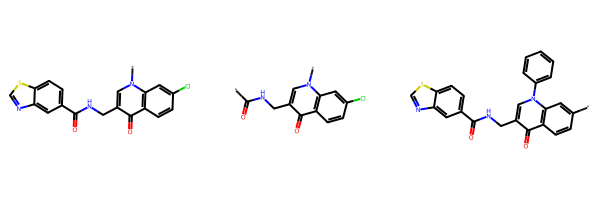

In [4]:
# Input scaffolds for sampling

scaffolds = ["O=C(c(cc1)cc2c1scn2)NCc(cn([*])c3c4ccc(Cl)c3)c4=O",
             "O=C([*])NCc(cn([*])c1c2ccc(Cl)c1)c2=O",
             "O=C(c(cc1)cc2c1scn2)NCc(cn(c3ccccc3)c4c5ccc([*])c4)c5=O",]

with open(os.path.join(config_folder, scaffold_file), "w") as f:
    for scaff in scaffolds:
        f.writelines(scaff + "\n")

# Visualise Scaffolds
        
mols = [Chem.MolFromSmiles(x) for x in scaffolds]
Chem.Draw.MolsToGridImage(mols)

In [5]:
# Setup toml file for initial reinforcement learning run

settings = f"""# REINVENT4 TOML input example for reinforcement/curriculum learning
#
#
# Curriculum learning in REINVENT4 is a multi-stage reinforcement learning
# run.  One or more stages (auto CL) can be defined.  But it is also
# possible to continue a run from any checkpoint file that is generated
# during the run (manual CL).  Currently checkpoints are written at the end
# of a run also when the run is forcefully terminated with Ctrl-C.


run_type = "staged_learning"
device = "{device}"  # set torch device e.g. "cpu"
tb_logdir = "{os.path.join(output_folder, "tb_logs")}"  # name of the TensorBoard logging directory
json_out_config = "{os.path.join(config_folder, "_staged_learning.json")}"  # write this TOML to JSON

[parameters]

# Uncomment one of the comment blocks below.  Each generator needs a model
# file and possibly a SMILES file with seed structures.  If the run is to
# be continued after termination, the agent_file would have to be replaced
# with the checkpoint file.

summary_csv_prefix = "{os.path.join(output_folder, "staged_learning")}"  # prefix for the CSV file
use_checkpoint = false  # if true read diversity filter from agent_file
purge_memories = false  # if true purge all diversity filter memories after each stage

## LibInvent
prior_file = "{os.path.join("../priors/",prior_file)}"
agent_file = "{os.path.join("../priors/",prior_file)}"
smiles_file = "{os.path.join(config_folder,scaffold_file)}"  # 1 scaffold per line with attachment points

batch_size = 64          # network

unique_sequences = true  # if true remove all duplicates raw sequences in each step
                         # only here for backward compatibility
randomize_smiles = true  # if true shuffle atoms in SMILES randomly


[learning_strategy]

type = "dap"      # dap: only one supported
sigma = 128       # sigma of the RL reward function
rate = 0.0001     # for torch.optim


[diversity_filter]  # optional, comment section out or remove if unneeded
                    # NOTE: also memorizes all seen SMILES

type = "IdenticalMurckoScaffold" # IdenticalTopologicalScaffold,
                                 # ScaffoldSimilarity, PenalizeSameSmiles
bucket_size = 25                 # memory size in number of compounds
minscore = 0.5                   # only memorize if this threshold is exceeded
minsimilarity = 0.4              # minimum similarity for ScaffoldSimilarity
penalty_multiplier = 0.5         # penalty factor for PenalizeSameSmiles

### Stage 1 - Initial reinforcement learning  run
[[stage]]

chkpt_file = '{os.path.join(model_folder, "checkpoint_1.chkpt")}'

termination = "simple"
max_score = {max_score}
min_steps = {min_steps}
max_steps = {max_steps}

[stage.scoring]
type = "geometric_mean"  # aggregation function
filename = "{os.path.join(config_folder,scoring_file)}"  # file with scoring setup for this stage
filetype = "toml"  # file format: TOML or JSON, no default, must be present"""

# Setup sampling runs to generate checkpoint files

for i in range(n_samples):
    settings += f"""
### Stage {i+2} - First sampling checkpoint
[[stage]]

chkpt_file = "{os.path.join(model_folder, f"checkpoint_{i+2}.chkpt")}"

termination = "simple"
max_score = 0.1
min_steps = {min_steps_sample}
max_steps = {min_steps_sample + 5}

[stage.scoring]
type = "geometric_mean"  # aggregation function
filename = "{os.path.join(config_folder,scoring_file)}"  # same scoring file as previous stage
filetype = "toml"  # file format: TOML or JSON, no default, must be present"""
    
with open(os.path.join(config_folder, config_file), "w") as f:
    f.writelines(settings)

In [6]:
# Run reinvent

os.system(f"reinvent {os.path.join(config_folder, config_file)} -l {os.path.join(output_folder, log_file)}")

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


0

### Analysis with tensorboard

In [12]:
import pandas as pd

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
# View training run for the agent
# If interactive window doesn't appear, tensorboard is avialable at http://localhost:6006/ if running

%tensorboard --logdir ../outputs/tb_logs_0 --host localhost